<a href="https://colab.research.google.com/github/lblum95/AML/blob/master/task1/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#############################  new branch #####################################
###### SCORE TO BEAT 0.74
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/AML
!git branch
%cd /content/drive/My Drive/Colab Notebooks/AML/task1

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/AML
  master
* yb-t1
/content/drive/My Drive/Colab Notebooks/AML/task1


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import sklearn.preprocessing as pp
import sklearn.linear_model as lm
from sklearn import decomposition
from sklearn.feature_selection import SelectKBest, chi2, f_regression, RFECV, f_classif
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold
import warnings
from scipy.spatial.distance import cdist
warnings.filterwarnings('ignore')

In [3]:
X_submit=pd.read_csv('data/X_test.csv',index_col='id')
X_learn=pd.read_csv('data/X_train.csv',index_col='id')
Y_learn=pd.read_csv('data/y_train.csv',index_col='id')
Y_submit=pd.read_csv('data/y_submit2.csv',index_col='id')


X_learn['Y']=Y_learn
X_learn['idx']=X_learn.index
X_learn['submit']=0
X_learn.set_index(["Y","idx","submit"],inplace=True)
X_learn.sort_index(axis=0,inplace=True)

X_submit['Y']=round(Y_submit)
X_submit['submit']=1
X_submit['idx']=X_submit.index
X_submit.set_index(["Y","idx","submit"],inplace=True)
X_submit.sort_index(axis=0,inplace=True)
X_submit.head()

x0             x1  ...           x830           x831
Y    idx   submit                            ...                              
46.0 135.0 1       11.820211  832442.843799  ...   98032.489369  106465.652350
49.0 241.0 1       10.622434            NaN  ...   88874.879212  108319.004379
50.0 198.0 1        9.649809  832442.832705  ...  115033.407745  103006.859214
     542.0 1        9.111847            NaN  ...  105813.396460  105070.269256
51.0 480.0 1        8.996661  832442.895186  ...   93192.135949  100041.830213

[5 rows x 832 columns]

# Replace the NaN's in the Learn dataset by taking the mean of the other samples who have the same outcome->Age

In [4]:
X_learn.loc[97].iloc[0,789]=X_learn.loc[95].iloc[:,789].mean()
X_learn.loc[97].iloc[1,789]=X_learn.loc[95].iloc[:,789].mean()
X_learn.loc[42].iloc[0,27]=X_learn.loc[43].iloc[0,27]
X_learn.loc[42].iloc[1,27]=X_learn.loc[43].iloc[0,27]
print(X_learn.isnull().sum().sum())
for k in np.unique(Y_learn):
  a=X_learn.loc[k,:]
  n,m=np.shape(a)
  if n<2:
    mna=X_learn.loc[k-1,:].mean()
    for j in range(m):
      if np.isnan(a.iloc[0,j]):
          a.iloc[0,j]=mna.iloc[j]
  else:
    mn=a.mean()
    for i in range(n):
      for j in range(m):
        if np.isnan(a.iloc[i,j]):
          a.iloc[i,j]=mn.iloc[j]

print(X_learn.isnull().sum().sum())
X_learn=X_learn.where(pd.notna(X_learn), X_learn.mean(), axis='columns')
print(X_learn.isnull().sum().sum())

76906
23
0


# Replace the NaN's in the Submit dataset. We used the Y estimates from a previous iteration

In [5]:
print(X_submit.isnull().sum().sum())

mna=X_submit.loc[52,:].mean()
for j in range(832):
    X_submit.iloc[0,j]=mna.iloc[j]

for k,_ in enumerate(np.unique(round(Y_submit))):
  a=X_submit.loc[np.unique(round(Y_submit))[k],:]
  n,m=np.shape(a)
  if n<2:
    mna=X_submit.loc[np.unique(round(Y_submit))[k-1],:].mean()
    for j in range(m):
      if np.isnan(a.iloc[0,j]):
          a.iloc[0,j]=mna.iloc[j]
  else:
    mn=a.mean()
    for i in range(n):
      for j in range(m):
        if np.isnan(a.iloc[i,j]):
          a.iloc[i,j]=mn.iloc[j]

print(X_submit.isnull().sum().sum())
X_submit=X_submit.where(pd.notna(X_submit), X_submit.mean(), axis='columns')
print(X_submit.isnull().sum().sum())

40610
20
0


In [6]:
X_learnCopy=X_learn.copy()
Y_learnCopy=Y_learn.copy()
X_submitCopy=X_submit.copy()
Y_submitCopy=Y_submit.copy()

In [7]:
X_learn=X_learnCopy.copy()
Y_learn=Y_learnCopy.copy()
X_submit=X_submitCopy.copy()
Y_submit=Y_submitCopy.copy()

# Fuse our Learn and Submit dataset and Scale Our Data with Standard Scacler and cull Data at 3.5 STDV

In [8]:
cullingFactor=3.5

X=pd.concat([X_learn,X_submit])
idx=X.index
scaler = pp.StandardScaler()
X = scaler.fit_transform(X)

X=pd.DataFrame(data=X, index=idx)
X_submit=X.loc[X.index.get_level_values('submit') ==1]
X_learn=X.loc[X.index.get_level_values('submit')==0]

X_submit=X_submit.where(X_submit<cullingFactor,cullingFactor)
X_learn=X_learn.where(X_learn<cullingFactor,cullingFactor)
X_submit=X_submit.where(X_submit>-cullingFactor,-cullingFactor)
X_learn=X_learn.where(X_learn>-cullingFactor,-cullingFactor)

X_submit.head()

0         1         2    ...       829       830       831
Y    idx   submit                                ...                              
46.0 135.0 1       0.029229 -0.517592 -0.352931  ...  0.076911  0.230132 -0.210117
49.0 241.0 1       0.615017 -0.517592  0.226268  ...  0.829850 -1.170368  1.260970
50.0 198.0 1      -0.395664 -0.952911 -0.458125  ... -0.273578  1.599234 -0.711720
     542.0 1      -0.954676 -0.952911  1.188538  ...  0.147371  0.623041  0.054537
51.0 480.0 1      -1.074368  1.320351  1.286509  ...  0.036101 -0.713267 -1.812797

[5 rows x 832 columns]

# Find the noisy samples in the Learn dataset compaired with the Submit

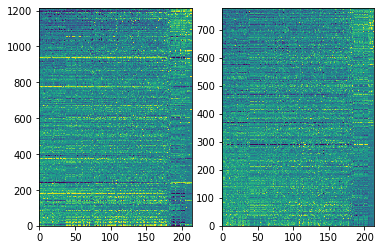

In [9]:
y=X_learn.index.get_level_values('Y')
corcoefs=[]
corname=[]
for i in range(832):
  x=X_learn.iloc[:,i]
  corcoefs.append(spearmanr(x,y)[0])
  corname.append(X_learn.iloc[:,i].name)
rank=pd.Series(data=corcoefs, index=corname).sort_values()

Selected_Features=(rank[abs(rank)>0.09]).index
X_learnSampleSelect=X_learn.copy()
X_submitSampleSelect=X_submit.copy()
X_learnSampleSelect=X_learnSampleSelect.loc[:,Selected_Features]
X_submitSampleSelect=X_submitSampleSelect.loc[:,Selected_Features]


axes = plt.subplot2grid((1, 2), (0, 0))
plt.pcolor(X_learnSampleSelect)
axes = plt.subplot2grid((1, 2), (0, 1))
plt.pcolor(X_submitSampleSelect)
plt.show()

(1212, 214)
(1090, 214)


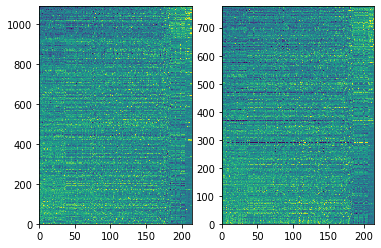

In [10]:
iso =IsolationForest(contamination=0.1).fit(X_learnSampleSelect,Y_learn)
print(np.shape(X_learnSampleSelect))
sampleS = (iso.predict(X_learnSampleSelect))!= -1
X_learnSampleSelect = X_learnSampleSelect[sampleS]
print(np.shape(X_learnSampleSelect))

axes = plt.subplot2grid((1, 2), (0, 0))
plt.pcolor(X_learnSampleSelect)
axes = plt.subplot2grid((1, 2), (0, 1))
plt.pcolor(X_submitSampleSelect)
plt.show()

# Kick out the noisy samples from Learn Reorder our Learn and Submit by idx

In [11]:
X_learn=X_learn.loc[X_learnSampleSelect.index]
Y_learn=Y_learn.loc[X_learnSampleSelect.index.get_level_values("idx")]

X_learn=X_learn.reorder_levels(['idx','Y','submit'])
X_submit=X_submit.reorder_levels(['idx','Y','submit'])
X_learn.sort_index(axis=0,inplace=True)
X_submit.sort_index(axis=0,inplace=True)
Y_learn.sort_index(axis=0,inplace=True)
X_submit.head()

,,,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831
idx,Y,submit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,68.0,1,-0.964967,-0.709353,0.528856,-0.027837,0.036007,0.360492,-1.381790,0.281412,-0.181815,-1.637592,1.038594,-0.947891,0.777901,0.029951,-1.173565,-0.673349,-1.710350,-0.163164,1.018382,0.070019,1.011694,-1.299454,-0.083187,1.480551,-0.854186,0.395291,-0.944291,-0.185635,-0.700428,-1.853761,-0.019147,0.398117,0.870046,0.408879,-0.122625,1.136867,1.837282,-0.354321,1.230244,-0.979281,...,-1.099684,-0.152306,1.192811,0.489642,-0.208108,0.099403,0.037955,0.355421,0.382753,0.351254,0.467899,0.028312,-1.248947,1.161442,0.467057,-0.349680,0.129285,-1.035670,0.658828,-0.728061,0.381559,1.396016,-0.632385,-1.711454,0.050715,-0.045805,0.482278,0.362853,1.271701,-0.475624,-0.025499,-0.817207,-0.897070,-0.055139,-1.020429,0.276155,-0.416771,-1.563061,0.416418,0.648091
1.0,73.0,1,1.757687,-1.185442,-0.519356,-0.361781,-0.190317,1.158331,1.578001,-0.026451,-0.007552,-0.919932,-0.663028,-1.448090,-0.259213,0.029113,0.357826,0.356064,1.729692,1.444342,0.045655,0.153447,-1.804102,2.034580,0.515233,-1.188423,-0.929802,0.542179,-0.728526,0.282200,-0.062875,-0.139305,0.212290,-0.758455,-0.405289,-1.505493,-1.426055,0.264440,-1.123415,-1.594089,-0.834791,0.933240,...,-0.035641,0.859913,0.782120,0.411533,0.101139,0.644492,0.347057,-0.996147,0.851753,1.177380,-1.315379,-0.675411,0.961226,0.889636,-0.286915,-1.536064,0.802188,1.502283,-0.236341,0.409209,0.636861,-1.397138,1.046043,-0.217410,1.581776,0.578952,-1.626315,0.599659,-1.174860,0.473376,0.511420,0.666423,0.868634,-0.419481,0.541789,-1.095807,1.302196,0.544646,0.088134,-0.085624
2.0,71.0,1,1.215471,-1.402102,-0.453301,1.216162,0.613943,-0.209899,0.053876,-0.633614,-1.616297,-1.459143,0.321378,-0.296437,0.105118,1.378569,-0.170724,-1.470600,-1.268948,-1.815245,0.475442,0.768773,-0.112653,1.531374,-0.180025,-1.462972,1.128424,-0.244242,1.496679,1.106408,0.902445,-0.408109,-0.417761,-1.109147,-1.015865,-1.272601,1.623878,1.390242,-1.766676,-1.318608,-0.424519,0.074863,...,-0.641287,0.614734,0.905677,0.171527,-2.429229,-0.244499,0.592230,-1.144534,-0.598398,0.508766,0.402935,-0.030397,-1.500418,0.964148,-0.436106,-0.134978,-0.485011,1.165579,-0.452332,0.037428,-1.231930,-0.279883,-0.388735,1.443962,1.838251,-0.349907,0.692791,-0.483086,-0.095522,-1.408543,-0.583149,0.079551,0.070324,-1.566094,-1.848343,-0.644686,-0.735053,-1.526152,0.689433,-0.563767
3.0,71.0,1,-0.375854,-1.382406,0.168882,0.547278,0.227714,-0.452259,-0.167804,0.182490,0.188103,1.351787,0.454494,-0.296437,1.254635,-0.275696,-0.246674,0.250229,1.762258,0.004429,0.650342,-0.659301,0.076899,1.237466,1.806800,0.084590,1.377137,1.157253,-0.801660,-1.085588,1.127675,1.160816,-0.006801,0.076476,-0.949050,2.596757,-0.220674,-0.225176,1.302888,0.849273,-0.642653,0.480064,...,-0.375401,0.833167,0.619220,1.258292,-0.435107,1.545577,0.239421,0.005261,-0.375226,1.751967,0.947768,0.336973,0.742352,-0.355918,0.343717,-0.575072,0.284303,-2.016154,0.913472,0.262233,0.636848,-0.058760,0.201211,-0.865552,1.196667,-1.359551,-0.026411,0.256929,-0.449680,0.428822,0.522831,-0.099318,0.495844,0.743263,-1.570794,0.017356,-0.200121,0.984193,0.331326,-1.630785
4.0,69.0,1,0.311102,0.471008,-1.459537,-1.311474,-0.654531,0.617152,-1.156572,0.067233,0.247909,0.940580,0.984300,-0.051320,0.216582,-0.294515,-0.205169,-1.579102,-0.738110,-1.892356,-0.092450,-1.076480,0.063139,1.374510,-0.615830,1.064745,-1.601761,0.779809,1.677360,1.322861,0.315386,-0.336885,1.167832,-0.957677,-0.317973,1.285314,1.379058,0.100145,1.587112,0.338909,0.528343,0.318276,...,0.511430,0.568472,0.573849,2.198777,-0.108132,-0.039473,1.384711,0.929114,0.639878,1.794868,0.602385,-0.545576,-0.948892,-1.385633,-0.588236,0

# Best Algo

In [12]:
x_train,x_test,y_train,y_test=train_test_split(X_learn,Y_learn,test_size=0.01)

model = SelectKBest(f_regression,k=197).fit(X_learn,Y_learn)
x_testFS = model.transform(x_test)
x_trainFS = model.transform(x_train)
X_submitFS = model.transform(X_submit)
model= SVR(C=89,max_iter =100000).fit(x_trainFS, y_train)
y_pred = model.predict(x_testFS)
Y_submit= model.predict(X_submitFS)
print(r2_score(y_test,y_pred))

Y_submit=pd.DataFrame(data=Y_submit, columns=['y'])
Y_submit.to_csv('data/y_submit2.csv', index_label='id')

0.6700296782511307


# Test Algos

In [ ]:
#estimator = SVR(kernel="linear")

estimator=lm.LinearRegression()
selector = RFECV(estimator, step=1)
selector = selector.fit(x_train, y_train)


* Test algo hyperparmater

Test max 0.6780755810821457  with C= 60


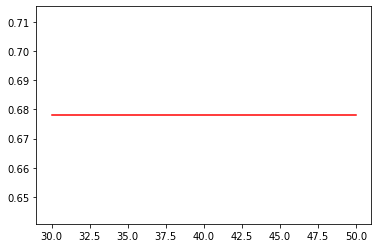

In [13]:
 scoress=[]
 param=[]
 for cc in np.arange(60,90,1):
  fold = KFold(n_splits = 5)
  scores=[]
  for train_index, test_index in fold.split(X_learn):
    x_train = X_learn.iloc[train_index]
    x_test = X_learn.iloc[test_index]
    y_train = Y_learn.iloc[train_index]
    y_test = Y_learn.iloc[test_index]
    model = SelectKBest(f_regression,k=201).fit(x_train,y_train)
    x_testFS = model.transform(x_test)
    x_trainFS = model.transform(x_train)
    model= SVR(C=cc,max_iter =100000).fit(x_trainFS, y_train)
    y_pred = model.predict(x_testFS)
    scores.append((r2_score(y_test,y_pred)))
  scoress.append(np.mean(scores))
  param.append(cc)
t = np.linspace(30,50,len(scoress))
print("Test max", max(scoress)," with C=", param[np.argmax(scoress)])
plt.plot(t, scoress, 'r',label='Training Score')
plt.show()

* Test number of features

Test max 0.6820902829121823  with N Features= 198


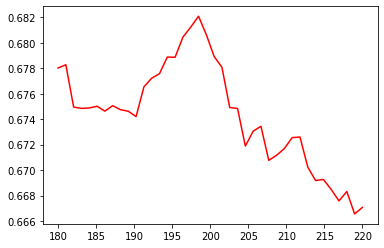

In [14]:
 scoress=[]
 param=[]
 for nfs in np.arange(180,220,1):
  fold = KFold(n_splits = 5)
  scores=[]
  for train_index, test_index in fold.split(X_learn):
    x_train = X_learn.iloc[train_index]
    x_test = X_learn.iloc[test_index]
    y_train = Y_learn.iloc[train_index]
    y_test = Y_learn.iloc[test_index]
    model = SelectKBest(f_regression,k=nfs).fit(x_train,y_train)
    x_testFS = model.transform(x_test)
    x_trainFS = model.transform(x_train)
    model= SVR(C=85,max_iter =100000).fit(x_trainFS, y_train)
    y_pred = model.predict(x_testFS)
    scores.append((r2_score(y_test,y_pred)))
  scoress.append(np.mean(scores))
  param.append(nfs)
t = np.linspace(180,220,len(scoress))
print("Test max", max(scoress)," with N Features=", param[np.argmax(scoress)])
plt.plot(t, scoress, 'r',label='Training Score')
plt.show()

# Big Ugly Nested loop

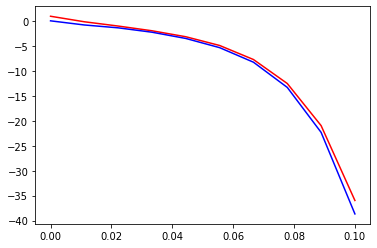

In [ ]:
 scoress=[]
 scoresss=[]
for alpha in np.arange(40,50,0.5):
  scoress=[]
  for cc in np.arange(50,230,2):
    fold = KFold(n_splits = 5)
    scores=[]
    for train_index, test_index in fold.split(X_learn):
      x_train = X_learn.iloc[train_index]
      x_test = X_learn.iloc[test_index]
      y_train = Y_learn.iloc[train_index]
      y_test = Y_learn.iloc[test_index]
      model = SelectKBest(f_regression,k=cc).fit(x_train,y_train)  
      x_testFS = model.transform(x_test)
      x_trainFS = model.transform(x_train)
      model=0
      model= SVR(C=alpha,max_iter =100000).fit(x_trainFS, y_train)
      y_pred = model.predict(x_testFS)
      scores.append((r2_score(y_test,y_pred)))
    scoress.append(np.mean(scores))
  scoresss.append(scoress)
  t = np.linspace(50,230,len(scoress))
  print("Test max", max(scoress),"alpha", alpha)
  plt.plot(t, scoress, 'r',label='Training Score')
  plt.show()

# Visualisation of the error

0.6724399044155722


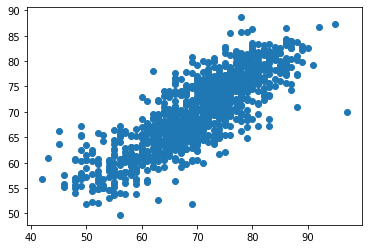

,y,yh
idx,,
296.0,42.0,56.777700
712.0,43.0,60.836378
536.0,45.0,66.197828
329.0,45.0,63.666629
196.0,46.0,55.128235
407.0,46.0,57.509254
322.0,46.0,55.734736
1070.0,48.0,56.305385
897.0,48.0,60.603394


In [15]:
fold = KFold(n_splits = 5)
y_preds=[]
y_tests=[]
for train_index, test_index in fold.split(X_learn):
  x_train = X_learn.iloc[train_index]
  x_test = X_learn.iloc[test_index]
  y_train = Y_learn.iloc[train_index]
  y_test = Y_learn.iloc[test_index]
  model = SelectKBest(f_regression,k=180).fit(x_train,y_train)  
  x_testFS = model.transform(x_test)
  x_trainFS = model.transform(x_train)
  model= SVR(C=46.415,max_iter =100000).fit(x_trainFS, y_train)
  y_pred = model.predict(x_testFS)
  scores.append((r2_score(y_test,y_pred)))
  y_preds.append(y_pred)
  y_tests.append(y_test)
print(np.mean(scores))
  
y_test=y_tests[0]
y_pred=pd.DataFrame(data=y_preds[0], index=y_test.index)
for i in range(4):
  y_test=pd.concat([y_test,y_tests[i+1]])
  yy_pred=pd.DataFrame(data=y_preds[i+1], index=y_tests[i+1].index)
  y_pred=pd.concat([y_pred,yy_pred])
plt.scatter(y_test, y_pred)
plt.show()
y_test['yh']=y_pred
y_test.sort_values(by='y').head(50)

# 4. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=100, random_state=0)
reg.fit(x_train, y_train)
yh_train = reg.predict(x_train)
yh_test = reg.predict(x_test)
score_train = r2_score(yh_train, y_train)
score_test = r2_score(yh_test, y_test)
print("Training", score_train, "Test", score_test)

Training 0.8914154170275576 Test -0.3408706268340107


# NOT NEEDED ANYMORE 
* Replace NaN's in Submit dataset by compairing to the closest match (euclidean distance) in the Learn dataset (to reduce time we select certain Features)

In [ ]:
model = SelectKBest(f_classif,k=800).fit(X_learn,Y_learn)
fs=model.get_support(indices=True)
X_learn=X_learn.iloc[:,fs]
X_submit=X_submit.iloc[:,fs]


mask=np.logical_not(np.isnan(X_submit))
n,m=np.shape(X_submit)  
for i in range(n):
  for j in range(m):
    if np.isnan(X_submit.iloc[i,j]):
      AX=np.matrix(X_submit.iloc[i,:][mask.iloc[i,:]])
      BX=X_learn.iloc[:,np.array(mask.iloc[i,:])]
      f= cdist(BX, AX, metric='euclidean')
      k=np.argmin(f)
      X_submit.iloc[i,j]=X_learn.iloc[k,j]
print(X_submit.isnull().sum().sum())

Training 1.0 Test -2.842302744425386


# Hierarichical clustering

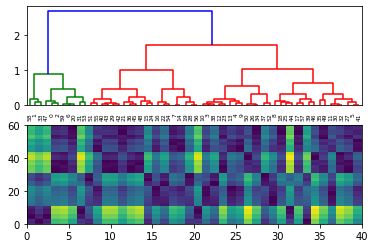

In [ ]:
import scipy
import pylab
import scipy.cluster.hierarchy as sch



# Generate random features and distance matrix.
x = scipy.rand(60)
D = scipy.zeros([60,40])
for i in range(60):
    for j in range(40):
        D[i,j] = abs(x[i] - x[j])


# Compute and plot second dendrogram.
axes = plt.subplot2grid((2, 1), (0, 0))
order = sch.linkage(D, method='centroid')
Z2 = sch.dendrogram(order)
idx2 = Z2['leaves']
A = D[idx2,:]
axes = plt.subplot2grid((2, 1), (1, 0))
plt.pcolor(A)